# Exercise Session 3: Motion Planning

In this exercise session, we will solve a motion planning problem by implementing a sampling-based and an optimization-based method. 

## Problem Statement

The motion planning problem is defined as follows:

Move a robot arm (e.g., UR10) from an initial position $q_0$ to a final position $q_T$, minimizing the end effector's travel distance. The task involves implementing two approaches:

1. **Sampling-based motion planning**: Implement the Rapidly-exploring Random Tree (RRT) algorithm to find a feasible path.
2. **Optimization-based motion planning**: Use trajectory optimization to refine the path and minimize the travel distance of the end-effector.



## Robot Initialization

In [1]:
import numpy as np
import pinocchio as pin
import pinocchio.casadi as cpin
from pinocchio.visualize import MeshcatVisualizer as PMV
import meshcat
import meshcat.transformations as tf
import time
from matplotlib import pyplot as plt
import sys
import casadi as ca
from rockit import *
from collections.abc import Callable

In [2]:
urdf_model_path = "ur10_robot.urdf"
mesh_dir = "meshes"

# Load the urdf model
model, collision_model, visual_model = pin.buildModelsFromUrdf(
    urdf_model_path, mesh_dir
)

# Create data required by the algorithms
data, collision_data, visual_data = pin.createDatas(
    model, collision_model, visual_model
)

# Define the equivalent casadi model and data
cmodel = cpin.Model(model)
cdata = cmodel.createData()

# Visualize robot
viz = PMV(model, collision_model, visual_model, collision_data=collision_data, visual_data=visual_data)
viz.initViewer(open=False)
viz.loadViewerModel(rootNodeName="robot")
viz.display(np.zeros(model.nv))

# Visualize start robot state
start_viz = PMV(model, collision_model, visual_model)
start_viz.initViewer(viz.viewer)
start_viz.loadViewerModel(rootNodeName="start_robot")
start_viz.display(np.zeros(model.nv))

# Visualize end robot state
end_viz = PMV(model, collision_model, visual_model)
end_viz.initViewer(viz.viewer)
end_viz.loadViewerModel(rootNodeName="end_robot")
end_viz.display(np.zeros(model.nv))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


### Exercise 1

Implement a function to get the position of the end-effector. Validate it by running the next block and checking in the visualizer if the red and green spheres match the end-effector's position.

In [14]:
def forward_kinematics_ee(q):
    """
    Compute the position of the end-effector given the joint configuration q.
    """
    # Update the robot state
    # pin.forwardKinematics(model, data, q)
    # frame_name = "ee_link"
    # T_pin = data.oMf[model.getFrameId(frame_name)]
    # # Extract the position of the end-effector
    # ee_position = T_pin.translation
    # ee_position = np.copy(ee_position)
    ee_position = np.copy((data.oMf[model.getFrameId("ee_link")].translation))
    return ee_position


In [15]:
material_red = meshcat.geometry.MeshLambertMaterial(color=16711680)
material_red.transparency = True
material_red.opacity = 0.5

material_green = meshcat.geometry.MeshLambertMaterial(color=65280)
material_green.transparency = True
material_green.opacity = 0.5

def generate_and_plot_start_end_configuration():
    q0 = pin.randomConfiguration(model)
    qT = pin.randomConfiguration(model)

    pos_0_ee = forward_kinematics_ee(q0)
    pos_T_ee = forward_kinematics_ee(qT)

    viz.viewer["start_ee"].set_object(meshcat.geometry.Sphere(0.05), material_green)
    viz.viewer["start_ee"].set_transform(tf.translation_matrix(pos_0_ee))

    viz.viewer["target_ee"].set_object(meshcat.geometry.Sphere(0.05), material_red)
    viz.viewer["target_ee"].set_transform(tf.translation_matrix(pos_T_ee))

    start_viz.display(q0)
    end_viz.display(qT)

    return q0, qT

q0, qT = generate_and_plot_start_end_configuration()

## Sampling-based planner

### Exercise 2:

Complete the RRT class implementation below. Verify the implementation by running the planner for a point mass problem in 3D (see next block).

Hint: To help debugging, you could bias the sampler to randomly sample $q_T$, which may help find a solution faster.

In [28]:
class RRT:
    def __init__(self, q_start: np.ndarray, q_goal: np.ndarray, q_limits: np.ndarray, forward_kinematics_ee: Callable, max_dist=0.1, goal_threshold=0.1):
        """
        Initialize the RRT planner.
        Parameters:
            q_start: Start configuration
            q_goal: Goal configuration
            q_limits: Joint limits (q_min, q_max)
            forward_kinematics_ee: Function to compute forward kinematics wich takes a configuration as input and returns the end-effector position
            max_dist: Maximum euclidian distance to move in one step
            goal_threshold: Distance threshold to consider the goal reached
        """
        self.name = "RRT"

        self.q_start = q_start
        self.q_goal = q_goal
        self.q_min, self.q_max = q_limits
        self.forward_kinematics_ee = forward_kinematics_ee
        self.max_dist = max_dist
        self.goal_threshold = goal_threshold

        self.reset()
    
    def reset(self):
        self.q = {
            0: [],
            1: []
        }
        self.ee_pos = {
            0: [],
            1: []
        }
        self.parent = {
            0: [],
            1: []
        }
        self.add_node(0, self.q_start)
        self.add_node(1, self.q_goal)
        self.parent[0].append(0)
        self.parent[1].append(0)
        self.found_goal = False
        self.switch_tree = False

        # index of the node that connect the two trees
        self.n_connect = {
            0: -1,
            1: 0
        }

    def add_node(self,tree_idx, q):
        """
        Add a node to the tree.
        """
        self.q[tree_idx].append(q)
        self.ee_pos[tree_idx].append(self.forward_kinematics_ee(q))

    def remove_node(self,tree_idx, n):
        """
        Remove the node n from the tree.
        """
        self.q[tree_idx].pop(n)
        self.ee_pos[tree_idx].pop(n)

    def add_edge(self, tree_idx, n_parent,n_child):
        """
        Add an edge between the node n_child and its parent n_parent.
        """
        self.parent[tree_idx].insert(n_child,n_parent)

    def remove_edge(self,tree_idx, n):
        """
        Remove the edge between the node n and its parent.
        """
        self.parent[tree_idx].pop(n)

    def number_of_nodes(self, tree_idx):
        """
        Return the number of nodes in the tree.
        """
        return len(self.q[tree_idx])

    def distance_q(self, tree_idx, n1, n2_or_q):
        """
        Compute the distance between two configurations or a configuration and a node.
        """
        if isinstance(n2_or_q, int):  # If n2_or_q is an index
            return np.linalg.norm(self.q[tree_idx][n1] - self.q[tree_idx][n2_or_q])
        else:  # If n2_or_q is a configuration (NumPy array)
            return np.linalg.norm(self.q[tree_idx][n1] - n2_or_q)

    def sample_q(self):
        """"
        Sample a random configuration."
        """
        # bias = 0.1
        # random = np.random.random()
        # if random < bias:
        #     return self.q_goal
        return np.random.uniform(self.q_min, self.q_max)

    def nearest(self,tree_idx, n):
        """"
        Find the nearest node in the tree to the node n.
        """
        nnear = 0
        min_dist = self.distance_q(tree_idx, 0, n)
        for i in range(1, self.number_of_nodes(tree_idx)):
            dist = self.distance_q(tree_idx, i, n)
            if dist < min_dist:
                min_dist = dist
                nnear = i
        return nnear

    def isFree(self, tree_idx):
        """"
        Check if the tree is collision-free.
        """
        return np.all(np.array([self.q[tree_idx][i] for i in range(self.number_of_nodes(tree_idx))]) >= self.q_min) and np.all(np.array([self.q[tree_idx][i] for i in range(self.number_of_nodes(tree_idx))]) <= self.q_max)

    def step(self,tree_idx, nnear,nnew, q_goal):
        """
        Extend the tree from the nearest node nnear to the new node nnew.
        If the new node is too far from the nearest node, move it closer.
        If the new node is withing the goal threshold, set found_goal to True and
        add the goal node if the new node is not the goal node.

        Parameters:
            tree_idx: Index of the tree
            nnear: Index of the nearest node
            nnew: Index of the new node
            q_goal: Goal configuration
        """
        # 1. Compute the distance between the new node and the nearest node
        dist = self.distance_q(tree_idx, nnear, nnew)
        # 2. If the distance is greater than max_dist, move the new node closer to the nearest node
        if dist > self.max_dist:
            # Compute the direction vector
            diff = (self.q[tree_idx][nnew] - self.q[tree_idx][nnear])
            # Move the new node closer to the nearest node
            q_new = self.q[tree_idx][nnear] + (self.max_dist / dist) * diff
            self.remove_node(tree_idx, nnew)
            self.add_node(tree_idx, q_new)
            
            if not self.isFree(tree_idx):
                # 3. If the new node is not free, remove it
                self.remove_node(tree_idx, nnew)
                self.switch_tree = True
                return
        self.add_edge(tree_idx, nnear, nnew)
        norm = np.linalg.norm(self.q[tree_idx][nnew] - q_goal)
        if norm < self.goal_threshold:
            self.found_goal = True
            if norm > 0.001:
                self.add_node(tree_idx, q_goal)
                self.add_edge(tree_idx, nnew, self.number_of_nodes(tree_idx)-1)
        
    

    # explore
    def extend(self, tree_idx, q, q_goal):
        """
        Extend the tree towards the configuration q.

        Parameters:
            tree_idx: Index of the tree
            q: Configuration to extend the tree towards
            q_goal: Goal configuration
        """
        n = self.number_of_nodes(tree_idx)
        self.add_node(tree_idx, q)
        if self.isFree(tree_idx):
            # 1. Find the nearest node in the tree to the configuration q
            nnear = self.nearest(tree_idx, n)
            self.step(tree_idx, nnear, n, q_goal)
        else:
            # 2. If the configuration is not free, remove the node
            self.remove_node(tree_idx, n)

    def _generate(self, max_iter=1000):
        """
        RRT algorithm.

        Parameters:
            max_iter: Maximum number of iterations
        
        Returns:
            Number of iterations
        """
        for i in range(max_iter):
            # 1. Sample a random configuration
            q = self.sample_q()
            # 3. Extend the tree towards the configuration q
            if self.extend(0, q, self.q_goal):
                # 4. If the goal is found, break
                if self.found_goal:
                    break
        return i

    def generate(self, max_iter=1000):
        """
        Generate the tree.
        """
        self.reset()

        t_start = time.time()

        i = self._generate(max_iter)

        t_gen = time.time() - t_start

        sys.stdout.flush()
        if self.found_goal:
            print(f"\r{self.name} generated in {i} iterations | {t_gen} seconds")
        else:
            print(f"\r{self.name} failed to find a solution in {i} iterations | {t_gen} seconds")
    
    def get_waypoints(self):
        """"
        Return the found waypoints to the goal.
        """
        route = []
        if self.found_goal:
            for tree_idx in range(2):
                n = self.number_of_nodes(tree_idx)
                last_n_route = self.n_connect[tree_idx] % self.number_of_nodes(tree_idx)
                for i in range(n-1, -1, -1):
                    if i==last_n_route:
                        last_n_route = self.parent[tree_idx][i]
                        if not (tree_idx == 1 and i == n-1): # ignore the connecting node of the second tree because it is already in the first tree
                            if tree_idx == 0:
                                route.insert(0, self.q[tree_idx][i])
                            else:
                                route.append(self.q[tree_idx][i])
                        # else:
                        #     assert np.linalg.norm(self.q[tree_idx][i]) == np.linalg.norm(route[-1])

        return route
    
    def plot_joint_space_sol(self):
        """
        Plot the joint space solution.
        """
        if self.found_goal:
            q_dim = self.q_start.shape[0]
            if q_dim % 2 == 0:
                _, axs = plt.subplots(q_dim//2, 2, figsize=(15, 5))
            else:
                _, axs = plt.subplots(q_dim//2+1, 2, figsize=(15, 5))
            
            route = self.get_waypoints()
            
            for i in range(len(route)):
                for j in range(q_dim):
                    if i < len(route)-1:
                        axs[j//2, j%2].plot([i, i+1], [route[i][j], route[i+1][j] ], 'b')
                    axs[j//2, j%2].plot([i], [route[i][j]], 'bo')
                    axs[j//2, j%2].set_title(f"q{j}")
            
            for j in range(q_dim):
                axs[j//2, j%2].plot([len(route)-1], [self.q_goal[j]], 'ro')
                axs[j//2, j%2].plot([0], [self.q_start[j]], 'go')
    
    def plot_ee(self, sol_only=False):
        """
        Plot the end-effector path.
        """

        _, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        for tree_idx in range(2):
            ee_pos = []
            n = self.number_of_nodes(tree_idx)
            for i in range(n):
                ee_pos.append(self.forward_kinematics_ee(self.q[tree_idx][i]))
            
            last_n_route = self.n_connect[tree_idx] % n
            for i in range(n-1, -1, -1):
                plot = not sol_only or not self.found_goal
                n_parent = self.parent[tree_idx][i]

                if i==last_n_route and self.found_goal:
                    color='b'
                    last_n_route = n_parent
                    plot=True
                else:
                    color='k'

                if plot:
                    axs[0].plot([ee_pos[i][0], ee_pos[n_parent][0]], [ee_pos[i][1], ee_pos[n_parent][1]], color)
                    axs[1].plot([ee_pos[i][0], ee_pos[n_parent][0]], [ee_pos[i][2], ee_pos[n_parent][2]], color)
                    axs[2].plot([ee_pos[i][1], ee_pos[n_parent][1]], [ee_pos[i][2], ee_pos[n_parent][2]], color)
        
        # plot goal + threshold
        ee_pos_goal = self.forward_kinematics_ee(self.q[1][0])
        axs[0].plot(ee_pos_goal[0], ee_pos_goal[1], 'rx')
        axs[1].plot(ee_pos_goal[0], ee_pos_goal[2], 'rx')
        axs[2].plot(ee_pos_goal[1], ee_pos_goal[2], 'rx')

        # plot start
        e_pos_start = self.forward_kinematics_ee(self.q[0][0])
        axs[0].plot(e_pos_start[0], e_pos_start[1], 'gx')
        axs[1].plot(e_pos_start[0], e_pos_start[2], 'gx')
        axs[2].plot(e_pos_start[1], e_pos_start[2], 'gx')

        # plot circle around goal
        circle = plt.Circle((ee_pos_goal[0], ee_pos_goal[1]), self.goal_threshold, color='r', fill=False)
        axs[0].add_artist(circle)
        circle = plt.Circle((ee_pos_goal[0], ee_pos_goal[2]), self.goal_threshold, color='r', fill=False)
        axs[1].add_artist(circle)
        circle = plt.Circle((ee_pos_goal[1], ee_pos_goal[2]), self.goal_threshold, color='r', fill=False)
        axs[2].add_artist(circle)
        axs[0].set_aspect('equal', 'box')
        axs[1].set_aspect('equal', 'box')
        axs[2].set_aspect('equal', 'box')

        axs[0].set_title('xy-plane')
        axs[1].set_title('xz-plane')
        axs[2].set_title('yz-plane')

    def plot_ee_3d(self, sol_only=False):
        """
        Plot the end-effector path in 3D.
        """

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        for tree_idx in range(2):
            n = self.number_of_nodes(tree_idx)
            ee_pos = []
            for i in range(n):
                ee_pos.append(self.forward_kinematics_ee(self.q[tree_idx][i]))

            last_n_route = self.n_connect[tree_idx] % self.number_of_nodes(tree_idx)
            for i in range(n-1, -1, -1):
                plot = not sol_only or not self.found_goal
                n_parent = self.parent[tree_idx][i]
                if i==last_n_route and self.found_goal:
                    color='b'
                    last_n_route = n_parent
                    plot=True
                else:
                    color='k'

                if plot:
                    ax.plot([ee_pos[i][0], ee_pos[n_parent][0]], [ee_pos[i][1], ee_pos[n_parent][1]], [ee_pos[i][2], ee_pos[n_parent][2]], color)
            
            ee_pos_goal = self.forward_kinematics_ee(self.q[1][0])
            ax.scatter(ee_pos_goal[0], ee_pos_goal[1], ee_pos_goal[2], c='r', marker='x')

            e_pos_start = self.forward_kinematics_ee(self.q[0][0])
            ax.scatter(e_pos_start[0], e_pos_start[1], e_pos_start[2], c='g', marker='x')
        ax.set_aspect('equal', 'box')


RRT generated in 9999 iterations | 148.01024746894836 seconds


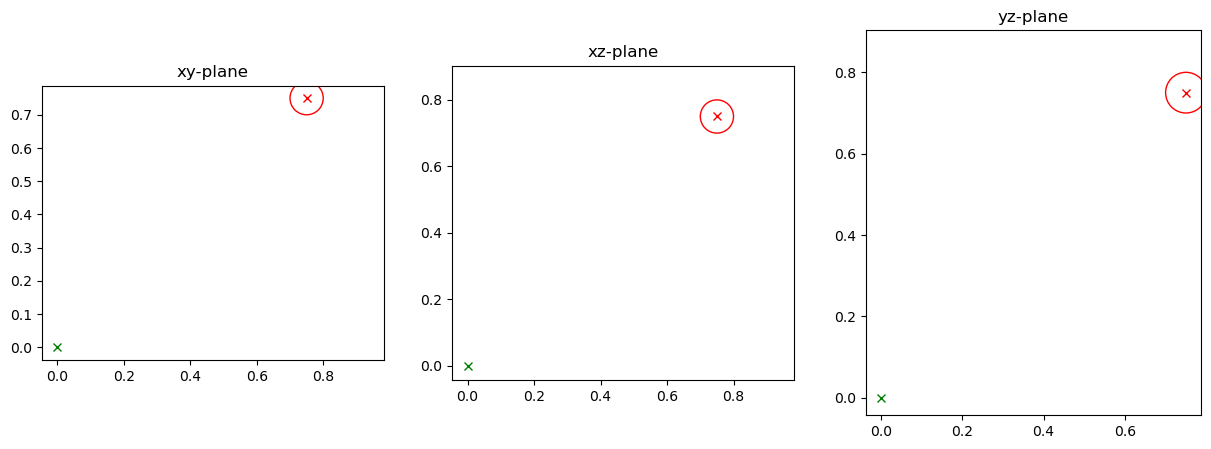

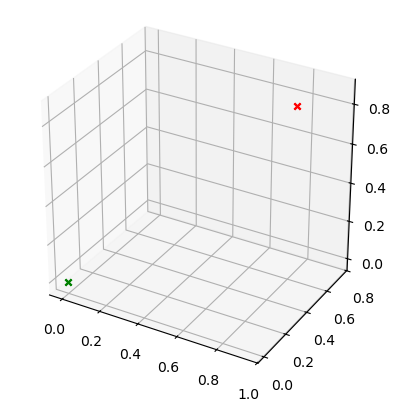

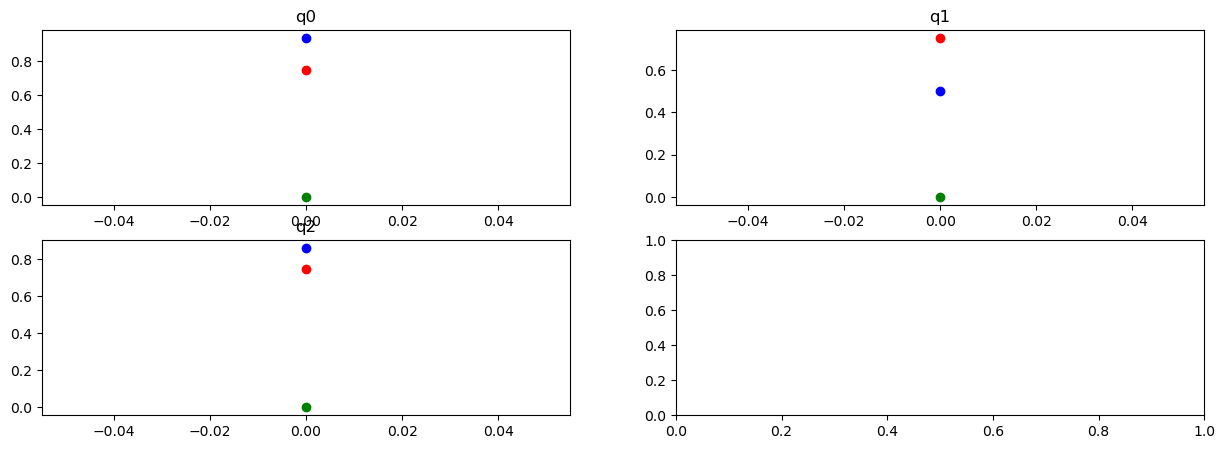

In [29]:
# test RRT
q_start_test = np.array([0,0,0])
q_goal_test = np.array([0.75,0.75,0.75])
q_limits_test = (np.zeros(3), np.ones(3))
forward_kinematics_ee_test = lambda q: q
max_dist = 0.1
goal_threshold = 0.05


planner_test = RRT(q_start_test, q_goal_test, q_limits_test, forward_kinematics_ee_test, max_dist, goal_threshold)
planner_test.generate(max_iter=10000)

sol_only = True
planner_test.plot_ee(sol_only)
planner_test.plot_ee_3d(sol_only)
planner_test.plot_joint_space_sol()


### Exercise 3

Do the same as in the previous exercise but now for the RRTConnect algorithm. Verify again with the point mass problem (see next block). If your implementation is correct, the generated waypoints should form a straight line.

In [142]:
class RRTConnect(RRT):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = "RRTConnect"

    def connect(self, tree_idx, q_goal, n_goal):
        """
        Connect the two trees.

        Parameters:
            tree_idx: Index of the tree
            q_goal: Goal configuration this tree is trying to connect to
            n_goal: Index of the goal node in the other tree
        """
        # ADD YOUR CODE HERE
        raise NotImplementedError

    def _generate(self, max_iter=1000):
        """
        RRTConnect algorithm.

        Parameters:
            max_iter: Maximum number of iterations

        Returns:
            Number of iterations
        """
        # ADD YOUR CODE HERE
        raise NotImplementedError
        return i

In [ ]:
# test RRTConnect
q_start_test = np.array([0,0,0])
q_goal_test = np.array([0.75,0.75,0.75])
q_limits_test = (np.zeros(3), np.ones(3))
forward_kinematics_ee_test = lambda q: q
max_dist = 0.1
goal_threshold = 0.05

planner_test = RRTConnect(q_start_test, q_goal_test, q_limits_test, forward_kinematics_ee_test, max_dist, goal_threshold)
planner_test.generate(max_iter=1000)

sol_only = True
planner_test.plot_ee(sol_only)
planner_test.plot_ee_3d(sol_only)
planner_test.plot_joint_space_sol()

# should be a straight line

### Exercise 4

Compare RRT and RRTConnect for the ur10 robot. Discuss.

In [ ]:
# ur10
q_start, q_goal = generate_and_plot_start_end_configuration()
q_limits = (model.lowerPositionLimit, model.upperPositionLimit)
max_dist = 30/180*np.pi # max 30 degrees difference between two nodes
goal_threshold = 0.03 # 3 cm

rrt_planner = RRT(q_start, q_goal, q_limits, forward_kinematics_ee, max_dist, goal_threshold)
rrt_planner.generate(max_iter=100000)

sol_only = True
rrt_planner.plot_ee(sol_only)
rrt_planner.plot_ee_3d(sol_only)
rrt_planner.plot_joint_space_sol()



In [ ]:
rrt_connect_planner = RRTConnect(q_start, q_goal, q_limits, forward_kinematics_ee, max_dist, goal_threshold)
rrt_connect_planner.generate(max_iter=100000)
sol_only = True
rrt_connect_planner.plot_ee(sol_only)
rrt_connect_planner.plot_ee_3d(sol_only)
rrt_connect_planner.plot_joint_space_sol()

## Optimization-based planner

In [ ]:
class OptiPlannerBase:
    def __init__(self, q_start: np.ndarray, q_goal: np.ndarray, q_limits: np.ndarray, v_limits: np.ndarray, u_limits: np.ndarray, forward_kinematics_ee: Callable, forward_kinematics_ee_ca: Callable, forward_dynamics_ca: Callable, velocity_ee_ca: Callable):
        """
        Initialize the OptiPlanner planner.
        Parameters:
            q_start: Start configuration
            q_goal: Goal configuration
            q_limits: Joint limits (q_min, q_max)
            v_limits: Joint velocity limits (v_min, v_max)
            u_limits: Joint torque limits (u_min, u_max)
            forward_kinematics_ee: Function to compute forward kinematics wich takes a configuration as input and returns the end-effector position
            forward_kinematics_ee_ca: Casadi function to compute forward kinematics wich takes a configuration as input and returns the end-effector position. 
            forward_dynamics_ca: Casadi function to compute forward dynamics which takes a configuration, velocity and control as input and returns the acceleration
            velocity_ee_ca: Casadi function to compute the end-effector velocity which takes a configuration and velocity as input and returns the end-effector velocity
        """

        self.q_start = q_start
        self.q_goal = q_goal
        self.q_min, self.q_max = q_limits
        self.v_min, self.v_max = v_limits
        self.u_min, self.u_max = u_limits
        self.forward_kinematics_ee = forward_kinematics_ee
        self.forward_kinematics_ee_ca = forward_kinematics_ee_ca
        self.forward_dynamics_ca = forward_dynamics_ca
        self.velocity_ee_ca = velocity_ee_ca

        self.x = None
        self.v = None
        self.u = None
        self.setup()

    
    def setup(self):
        """
        Setup the optimization problem.
        Make sure to set self.ocp, self.x, self.v, self.u
        """
        # Create the optimization problem
        ocp = Ocp(t0=0, T=10)
        
        x = ocp.state(len(self.q_min))
        v = ocp.control(len(self.q_min))
        
        

    def solve(self, waypoints_rrt=None, x_init=1, v_init=0, u_init=0, N=31):
        """
        Solve the optimization problem.

        Parameters:
            waypoints_rrt: Waypoints from RRT or RRTConnect
            x_init: Initial configuration, if x == -1, random configuration is used, if x == 1, linear interpolation between q_start and q_goal is used
            v_init: Initial velocity
            u_init: Initial control
            N: Number of control intervals
        """
        method = MultipleShooting(N=N, intg='rk')
        self.ocp.method(method)

        if waypoints_rrt is not None:
            waypoints_rrt = np.array(waypoints_rrt)
            # interplate waypoints
            x_original = np.linspace(0, 1, waypoints_rrt.shape[0])
            x_target = np.linspace(0, 1, N+1)
            x_init = np.array([np.interp(x_target, x_original, waypoints_rrt[:, i]) for i in range(waypoints_rrt.shape[1])])
        elif x_init == -1:
            x_init = np.random.uniform(self.q_min, self.q_max)
        elif x_init == 1:
            x_init = np.linspace(self.q_start, self.q_goal, N).transpose()
        
        if v_init == 0:
            v_init = np.zeros((N, len(self.q_start))).transpose()
        
        if u_init == 0:
            u_init = np.zeros((N, len(self.q_start))).transpose()

        self.ocp.set_initial(self.x, x_init)
        self.ocp.set_initial(self.v, v_init)
        if self.u is not None:
            self.ocp.set_initial(self.u, u_init)

        self.sol = self.ocp.solve()
    
    def get_trajectory(self):
        """
        Return the trajectory.
        """
        _, qq = self.sol.sample(self.x, grid='control')
        return qq

    def plot_joint_space_sol(self, q_only=False):
        q_dim = self.q_start.shape[0]
        if q_dim % 2 == 0:
            _, axs = plt.subplots(q_dim//2, 2, figsize=(15, 5))
        else:
            _, axs = plt.subplots(q_dim//2+1, 2, figsize=(15, 5))
        
        qq = self.get_trajectory()

        for i in range(qq.shape[0]-1):
            for j in range(q_dim):
                axs[j//2, j%2].plot([i, i+1], [float(qq[i][j]), float(qq[i+1][j]) ], 'b')
                axs[j//2, j%2].plot([i], [qq[i][j]], 'bo')
                axs[j//2, j%2].set_title(f"q{j}")
        
        for j in range(q_dim):
            axs[j//2, j%2].plot([len(qq)-1], [self.q_goal[j]], 'ro')
            axs[j//2, j%2].plot([0], [self.q_start[j]], 'go')

        if not q_only:
            # velocity
            _, vv = self.sol.sample(self.v, grid='control')

            if q_dim % 2 == 0:
                _, axs = plt.subplots(q_dim//2, 2, figsize=(15, 5))
            else:
                _, axs = plt.subplots(q_dim//2+1, 2, figsize=(15, 5))

            for i in range(qq.shape[0]-1):
                for j in range(q_dim):
                    axs[j//2, j%2].plot([i, i+1], [vv[i][j], vv[i+1][j] ], 'b')
                    axs[j//2, j%2].plot([i], [vv[i][j]], 'bo')
                    axs[j//2, j%2].set_title(f"v{j}")
            
            # control
            if self.u is not None:
                _, uu = self.sol.sample(self.u, grid='control')

                if q_dim % 2 == 0:
                    _, axs = plt.subplots(q_dim//2, 2, figsize=(15, 5))
                else:
                    _, axs = plt.subplots(q_dim//2+1, 2, figsize=(15, 5))
                for i in range(qq.shape[0]-1):
                    for j in range(q_dim):
                        axs[j//2, j%2].plot([i, i+1], [float(uu[i][j]), float(uu[i+1][j]) ], 'b')
                        axs[j//2, j%2].plot([i], [uu[i][j]], 'bo')
                        axs[j//2, j%2].set_title(f"u{j}")

    def plot_ee(self, sol_only=False):
        qq = self.get_trajectory()

        _, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        ee_pos = []
        for i in range(qq.shape[0]):
            ee_pos.append(self.forward_kinematics_ee(qq[i]))

        for i in range(len(ee_pos)-1):
            axs[0].plot([float(ee_pos[i][0]), float(ee_pos[i+1][0])], [float(ee_pos[i][1]), float(ee_pos[i+1][1])], 'b')
            axs[1].plot([float(ee_pos[i][0]), float(ee_pos[i+1][0])], [float(ee_pos[i][2]), float(ee_pos[i+1][2])], 'b')
            axs[2].plot([float(ee_pos[i][1]), float(ee_pos[i+1][1])], [float(ee_pos[i][2]), float(ee_pos[i+1][2])], 'b')
        
        # plot goal + threshold
        ee_pos_goal = ee_pos[-1]
        axs[0].plot(ee_pos_goal[0], ee_pos_goal[1], 'rx')
        axs[1].plot(ee_pos_goal[0], ee_pos_goal[2], 'rx')
        axs[2].plot(ee_pos_goal[1], ee_pos_goal[2], 'rx')

        # plot start
        e_pos_start = ee_pos[0]
        axs[0].plot(e_pos_start[0], e_pos_start[1], 'gx')
        axs[1].plot(e_pos_start[0], e_pos_start[2], 'gx')
        axs[2].plot(e_pos_start[1], e_pos_start[2], 'gx')

        axs[0].set_aspect('equal', 'box')
        axs[1].set_aspect('equal', 'box')
        axs[2].set_aspect('equal', 'box')

        axs[0].set_title('xy-plane')
        axs[1].set_title('xz-plane')
        axs[2].set_title('yz-plane')
    
    def plot_ee_3d(self):
        _, qq = self.sol.sample(self.x, grid='control')

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        ee_pos = []
        for i in range(qq.shape[0]):
            ee_pos.append(self.forward_kinematics_ee(qq[i]))

        for i in range(len(ee_pos)-1):
            ax.plot([float(ee_pos[i][0]), float(ee_pos[i+1][0])], [float(ee_pos[i][1]), float(ee_pos[i+1][1])], [float(ee_pos[i][2]), float(ee_pos[i+1][2])], 'b')
        
        ax.scatter(ee_pos[-1][0], ee_pos[-1][1], ee_pos[-1][2], c='r', marker='x')
        ax.scatter(ee_pos[0][0], ee_pos[0][1], ee_pos[0][2], c='g', marker='x')
        ax.set_aspect('equal', 'box')



### Exercise 5
Implement an optimal planner with velocity control (i.e. u = v) that minmizes the end-effector's travel distance. Verify your implementation with the next block.

Hint: How can you track the distance of the end-effector?

In [44]:
class OptiPlannerVelocity(OptiPlannerBase):
    def setup(self):
        """
        Setup the optimization problem.
        Implement an optimal planner with velocity control (i.e. u = v) that minmizes the end-effector's travel distance. Verify your implementation with the next block.
        """
        # Make sure to set self.ocp, self.x, self.v, self.u if needed.
        
        # Create the optimization problem
        self.ocp = Ocp()
        self.x = self.ocp.variable('x', self.q_start.shape[0], 1)
        self.v = self.ocp.variable('v', self.q_start.shape[0], 1)
        self.u = None
        # Set the initial state
        self.ocp.set_initial(self.x, self.q_start)
        if self.u is not None:
            self.ocp.set_initial(self.u, np.zeros_like(self.q_start))
        self.ocp.set_initial(self.v, np.zeros_like(self.q_start))

In [45]:
# Test OptiPlanner
q_start_test = np.array([0,0,0])
q_goal_test = np.array([0.75,0.75,0.75])
q_limits_test = (np.zeros(3), np.ones(3))
v_limits_test = (-np.ones(3), np.ones(3))
u_limits_test = (-np.ones(3), np.ones(3))

q_sym = ca.MX.sym('q', 3)
v_sym = ca.MX.sym('v', 3)
u_sym = ca.MX.sym('u', 3)
forward_kinematics_ee_test = ca.Function('forward_kinematics_ee_test', [q_sym], [q_sym])
forward_dynamics_ca_test = ca.Function('forward_dynamics_ca_test', [q_sym, v_sym, u_sym], [u_sym])
velocity_ee_ca_test = ca.Function('velocity_ee_ca_test', [q_sym, v_sym], [v_sym])

opti_planner_test = OptiPlannerVelocity(q_start_test, q_goal_test, q_limits_test, v_limits_test, u_limits_test,forward_kinematics_ee_test, forward_kinematics_ee_test, forward_dynamics_ca_test, velocity_ee_ca_test)
opti_planner_test.solve()
opti_planner_test.plot_ee()
opti_planner_test.plot_joint_space_sol()
opti_planner_test.plot_ee_3d()

# should be a straight line

NotImplementedError: Wrong number or type of arguments for overloaded function 'GenMX_sym'.
  Possible prototypes are:
    sym(str,int,int)
    sym(str,(int,int))
    sym(str,Sparsity)
    sym(str,Sparsity,int)
    sym(str,int,int,int)
    sym(str,Sparsity,int,int)
    sym(str,int,int,int,int)
  You have: '(str,str,int)'


### Exercise 6

Implement an optimal planner with torque control (i.e. u = $\tau$) that minmizes the end-effector's travel distance.


In [160]:
class OptiPlannerTorque(OptiPlannerBase):
    def setup(self):
        """
        Setup the optimization problem.
        """
        # ADD YOUR CODE HERE
        # Make sure to set self.ocp, self.x, self.v, self.u if needed.
        raise NotImplementedError

In [ ]:
opti_planner_test = OptiPlannerTorque(q_start_test, q_goal_test, q_limits_test, v_limits_test, u_limits_test,forward_kinematics_ee_test, forward_kinematics_ee_test, forward_dynamics_ca_test, velocity_ee_ca_test)
opti_planner_test.solve()
opti_planner_test.plot_ee()
opti_planner_test.plot_joint_space_sol()
opti_planner_test.plot_ee_3d()

# should be a straight line

### Exercise 7

Complete the script below, then compare the optimization planners for the UR10 robot. Use the waypoints from the sampling-based planners as an initial trajectory for the solver by passing them to the solve function. Additionally, test a random initial guess for the joint configurations by setting x_init = -1 in the solve function. Discuss your findings.

In [ ]:
# ur10
# q_start, q_goal = generate_and_plot_start_end_configuration()
q_limits = (model.lowerPositionLimit, model.upperPositionLimit)
v_limits = (-model.velocityLimit, model.velocityLimit)
u_limits = (-model.effortLimit, model.effortLimit)

cq = ca.SX.sym('q', model.nq)
cdq = ca.SX.sym('dq', model.nq)
ctau = ca.SX.sym('tau', model.nq)
# Compute the forward dynamics
cddq = cpin.aba(cmodel, cdata, cq, cdq, ctau)
forward_dynamics_ca = ca.Function('forward_dynamics_ca', [cq, cdq, ctau], [ca.cse(cddq)])

def _forward_kinematics_ee_ca(q):
    """
    Compute the end-effector position of the UR10 using the Casadi implementation of Pinocchio.
    """
    # ADD YOUR CODE HERE
    raise NotImplementedError

def _velocity_ee_ca(q, v):
    """
    Compute the end-effector velocity of the UR10 using the Casadi implementation of Pinocchio.
    """
    # ADD YOUR CODE HERE
    raise NotImplementedError

forward_kinematics_ee_ca = ca.Function('forward_kinematics_ee_ca', [cq], [_forward_kinematics_ee_ca(cq)])
velocity_ee_ca = ca.Function('velocity_ee_ca', [cq, cdq], [_velocity_ee_ca(cq, cdq)])

opti_planner_vel = OptiPlannerVelocity(q_start, q_goal, q_limits, v_limits, u_limits, forward_kinematics_ee, forward_kinematics_ee_ca, forward_dynamics_ca, velocity_ee_ca)
opti_planner_vel.solve()

opti_planner_vel.plot_ee()
opti_planner_vel.plot_joint_space_sol()
opti_planner_vel.plot_ee_3d()

In [ ]:
opti_planner_tor = OptiPlannerTorque(q_start, q_goal, q_limits, v_limits, u_limits, forward_kinematics_ee, forward_kinematics_ee_ca, forward_dynamics_ca, velocity_ee_ca)
opti_planner_tor.solve()

opti_planner_tor.plot_ee()
opti_planner_tor.plot_joint_space_sol()
opti_planner_tor.plot_ee_3d()

### Exercise 8

Simulate the trajectories in the visualizer. Is the planner we implemented complete? If not, what is missing and how could we add this?

In [25]:
def simulate_trajectory(route, duration=10):
    refresh_rate = 0.05

    # interpolate
    x_original = np.linspace(0, 1, route.shape[0])
    x_target = np.linspace(0, 1, int(duration / refresh_rate))

    qq_interp = np.array([np.interp(x_target, x_original, route[:, i]) for i in range(route.shape[1])]).T

    for i in range(len(qq_interp)):
        viz.display(qq_interp[i])
        time.sleep(refresh_rate)

In [26]:
simulate_trajectory(opti_planner_vel.get_trajectory(), duration=10)